# Swing-up Control of the Acrobot

TODO put summary/abstract text from the report in here

In [1]:
%matplotlib inline

from yapss import Problem
import numpy as np
import matplotlib.pyplot as plt
import scipy

## Acrobot Parameters
These parameters describe the physical acrobot and are as defined in [1]. Additionally, we define gravity as $9.8\: \mathrm{m/s^2}$.

In [2]:
### Acrobot parameters (taken from Spong 1995)
# Masses (kg)
m1 = 1.
m2 = 1.
# Link lengths (m)
l1 = 1.
l2 = 2.
# Centers of masses (m)
lc1 = l1/2.
lc2 = l2/2.
# Moments of inertia
I1 = 0.083
I2 = 0.33
# Gravity
g = 9.8

## Acrobot Dynamics & Objective Function(s)

Below, we define the dynamics of the acrobot and possible cost functions to use in our optimal control problem formulation. Note that there are two dynamics functions below--they produce the same dynamics, but with different reference frames. `dynamics_spong` measures the first link angle from the horizontal as defined in [1], while `dynamics_tedrake` measures the state angles from down as defined in [3]. The mass matrix in `dynamics_tedrake` is actually taken from [2], as there appeared to be errors in simulation when using the mass matrix from [3] (commented out in the function below).

In [72]:
# Simple helper function
def inv_2x2(A):
    """Returns inverse of 2x2 matrix A"""
    assert A.shape == (2, 2), "Wrong shape for matrix A, cannot invert"

    a11 = A[0,0]
    a12 = A[0, 1]
    a21 = A[1, 0]
    a22 = A[1,1]

    det = a22 * a11 - a12 * a21
    assert det != 0, "Singular matrix!"
    return np.array([[a22/det, -a12/det],
                     [-a21/det, a11/det]])

def dynamics_tedrake(q1, q2, q1_dot, q2_dot, u, b1=0., b2=0.):
    """TODO"""
    # M(q)*q_ddot + C(q, q_dot) = tau_g(q) + Bu
    # q = [q1, q2]^T
    # B = [0, 1]^T
    # Source: https://underactuated.csail.mit.edu/acrobot.html#section1,
    # but with mass matrix from DOI:10.1016/j.ifacol.2016.10.194
    # Coriolis and gravity terms match between sources (accounting for from axes conventions)

    a1 = m1*lc1**2 + m2*l1**2 + I1
    a2 = m2*lc2**2 + I2
    a3 = m2*l1*lc2

    # M, mass matrix
    # M = np.array([[I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*np.cos(q2), I2 + m2*l1*lc2*np.cos(q2)],
    #               [I2 + m2*l1*lc2*np.cos(q2), I2]])  # this is from Tedrake and is wrong
    M = np.array([[a1 + a2 + 2*a3*np.cos(q2), a2 + a3*np.cos(q2)],
                  [a2 + a3*np.cos(q2), a2]])

    # C, Coriolis terms
    C = np.array([-2*a3*np.sin(q2)*q2_dot*q1_dot - a3*np.sin(q2)*q2_dot**2,
                  a3*np.sin(q2)*q1_dot**2])

    # tau_g, gravity terms
    tau_g = np.array([-m1*g*lc1*np.sin(q1) - m2*g*(l1*np.sin(q1) + lc2*np.sin(q1 + q2)),
                      -m2*g*lc2*np.sin(q1 + q2)])
    
    # Damping terms
    tau_g -= np.array([b1 * q1_dot, b2 * q2_dot])

    q_ddot = inv_2x2(M) @ (-C + tau_g + np.array([0, u])).reshape((2,1))
    return [q1_dot, q2_dot, q_ddot[0,0], q_ddot[1,0]]

def dynamics_spong(q1, q2, q1_dot, q2_dot, u):
    """
    Computes and returns $\ddot{q}$ as defined in:
    Mark Spong, "The Swingup Control Problem for the Acrobot", IEEE Control Systems
    Magazine, vol. 15, no. 1, pp. 49-55, February, 1995.

    This function uses the exact variable naming and angle/axis conventions as in the paper.
    """
    d11 = m1*lc1**2 + m2*(l1**2 + lc2**2 + 2*l1*lc2*np.cos(q2)) + I1 + I2
    d22 = m2*lc2**2 + I2
    d12 = m2*(lc2**2 + l1*lc2*np.cos(q2)) + I2
    d21 = m2*(lc2**2 + l1*lc2*np.cos(q2)) + I2
    h1 = -m2*l1*lc2*np.sin(q2)*q2_dot**2 - 2*m2*l1*lc2*np.sin(q2)*q2_dot*q1_dot
    h2 = m2*l1*lc2*np.sin(q2)*q1_dot**2
    phi1 = (m1*lc1 + m2*l1)*g*np.cos(q1) + m2*lc2*g*np.cos(q1 + q2)
    phi2 = m2*lc2*g*np.cos(q1 + q2)

    det = d22 * d11 - d12 * d21
    d_inv = np.array([[d22/det, -d12/det],
                      [-d21/det, d11/det]])
    q_ddot = d_inv @ np.array([-h1 - phi1, -h2 - phi2 + u]).reshape((2,1))

    return [q1_dot, q2_dot, q_ddot[0,0], q_ddot[1,0]]

def cost_u_only(Q, R, q1, q2, q1_dot, q2_dot, u):
    """TODO"""
    return R * u**2

def cost_min_u_t(Q, R, q1, q2, q1_dot, q2_dot, u):
    return 1 + R * u**2

In [63]:
### Helper plotting functions
def compute_hamiltonian(state, u, costate, dynamics, cost_fn, Q, R):
    cost = cost_fn(Q, R, state[0], state[1], state[2], state[3], u)
    hamiltonian = np.zeros(costate[0].shape)
    for i in range(len(costate)):
        hamiltonian += costate[i] * dynamics[i]
    hamiltonian += cost
    return hamiltonian

def plot_state(time, q1, q2, q1_dot, q2_dot, title=None):
    fig = plt.figure(figsize=(12, 4))
    if title is not None:
        fig.suptitle(title)
    ax1 = fig.add_subplot(121)
    ax1.plot(time, q1, label="$q_1$")
    ax1.plot(time, q2, label="$q_2$")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Angle (rad)")
    plt.grid()
    plt.legend()

    ax2 = fig.add_subplot(122)
    ax2.plot(time, q1_dot, label="$\\dot{q}_1$")
    ax2.plot(time, q2_dot, label="$\\dot{q}_2$")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Angular velocity (rad/s)")
    plt.grid()
    plt.legend()

def plot_input(time, u):
    fig = plt.figure()
    plt.plot(time, u, label="$\\tau$")
    fig.suptitle("Optimal input")
    plt.xlabel("Time (s)")
    plt.ylabel("Torque (N-m)")
    plt.grid()

def plot_hamiltonian(time, state, u, costate, dynamics, cost_fn=cost_u_only, Q=1, R=10):
    hamiltonian = compute_hamiltonian(state, u, costate, dynamics, cost_fn, Q, R)
    fig = plt.figure()
    fig.suptitle("Hamiltonian, $\\mathcal{H}=\\lambda^T f$")
    plt.plot(time, hamiltonian)
    plt.xlabel("Time (s)")
    plt.grid()

def plot_all(time, state, time_u, u, costate, dynamics, cost_fn=cost_u_only, Q=1, R=10, title=None):
    fig = plt.figure(figsize=(12, 9))
    if title is not None:
        fig.suptitle(title, y=0.92)

    ax1 = fig.add_subplot(221)
    ax1.plot(time, state[0], label="$q_1$")
    ax1.plot(time, state[1], label="$q_2$")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Angle (rad)")
    plt.grid()
    plt.legend()

    ax2 = fig.add_subplot(222, sharex=ax1)
    ax2.plot(time, state[2], label="$\\dot{q}_1$")
    ax2.plot(time, state[3], label="$\\dot{q}_2$")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Angular velocity (rad/s)")
    plt.grid()
    plt.legend()

    ax3 = fig.add_subplot(223, sharex=ax1)
    ax3.plot(time_u, u, label="$\\tau")
    ax3.set_xlabel("Time (s)")
    ax3.set_ylabel("Torque (N-m)")
    plt.grid()

    hamiltonian = compute_hamiltonian(state, u, costate, dynamics, cost_fn, Q, R)
    ax4 = fig.add_subplot(224, sharex=ax1)
    ax4.plot(time_u, hamiltonian)
    ax4.set_xlabel("Time (s)")
    ax4.set_ylabel("Hamiltonian, $\\mathcal{H}=\\lambda^T f$")
    plt.grid()


## Problem Definition

TODO copy from report

In [75]:
## Wrapped in a function to easily do multiple runs with different parameters
def acrobot_swing_up(dynamics_fn, cost_fn, u_max, t0, tf, x0, Q=1, R=10,
                     xf=None, x_max=None, state_guess=None, time_guess=None,
                     b1=0., b2=0.,
                     min_time=False):
    def objective(arg):
        arg.objective = arg.phase[0].integral[0]

    def continuous(arg):
        q1, q2, q1_dot, q2_dot = arg.phase[0].state
        u, = arg.phase[0].control  # elbow torque
        arg.phase[0].dynamics[:] = dynamics_fn(q1, q2, q1_dot, q2_dot, u)
        arg.phase[0].integrand[0] = cost_fn(Q, R, q1, q2, q1_dot, q2_dot, u)

    # Acrobot state: [theta1, theta2, theta1_dot, theta2_dot]
    # input: [torque] (at elbow joint only)
    problem = Problem(name="acrobot", nx=[4], nu=[1], nq=[1])

    functions = problem.functions
    functions.objective = objective
    functions.continuous = continuous

    ## Set bounds
    bounds = problem.bounds.phase[0]

    # Initial conditions
    bounds.initial_time.lower = bounds.initial_time.upper = t0
    bounds.initial_state.lower = bounds.initial_state.upper = x0

    if xf is not None:
        bounds.final_state.lower = bounds.final_state.upper = xf
    
    # Final time
    if min_time:
        bounds.final_time.lower = 0
        bounds.final_time.upper = tf*2
    else:
        bounds.final_time.lower = bounds.final_time.upper = tf

    # Control bounds (torque, N*m)
    bounds.control.lower[:] = (-u_max,)
    bounds.control.upper[:] = (u_max,)

    # State bounds
    if x_max is not None:
        bounds.state.lower = -1 * np.array(x_max)
        bounds.state.upper = x_max
    
    ## Compute initial guess if not given
    if state_guess is None and time_guess is None:
        if xf is None:  # assume this means passive dynamics
            sol = scipy.integrate.solve_ivp(lambda t,y: dynamics_fn(*y, 0, b1=b1, b2=b2), [t0, tf], x0)
            state_guess = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]
            time_guess = sol.t
        else:
            # Simulate the swing-up backwards
            sol = scipy.integrate.solve_ivp(lambda t,y: dynamics_fn(*y, 0, b1=b1, b2=b2),
                                            [t0, tf],
                                            [xf[0] - 0.02, xf[1], xf[2], xf[3]])
            state_guess = [np.flip(sol.y[0]), np.flip(sol.y[1]),
                           np.flip(-1*sol.y[2]), np.flip(-1*sol.y[3])]
            time_guess = sol.t

    ## Set initial guess
    initial_guess = problem.guess.phase[0]
    initial_guess.time = time_guess
    initial_guess.state = state_guess

    ## Plot the initial guess
    q1, q2, q1_dot, q2_dot = state_guess
    plot_state(time_guess, q1, q2, q1_dot, q2_dot, title="Initial state trajectory guess")

    ## Mesh and solver settings
    # Suggested 3-400 points here
    m, n = 40, 10
    problem.mesh.phase[0].collocation_points = m * (n,)
    problem.mesh.phase[0].mesh_fraction = m * (1.0 / m,)

    problem.derivatives.order = "second"
    problem.derivatives.method = "auto"
    problem.spectral_method = "lgl"
    problem.ipopt_options.tol = 1e-8
    problem.ipopt_options.max_iter = 1000

    ## Solve the optimization
    output = problem.solve()

    # Extract information from solution
    time = output.solution.phase[0].time
    time_u = output.solution.phase[0].time_u
    state = output.solution.phase[0].state
    costate = output.solution.phase[0].costate
    dynamics = output.solution.phase[0].dynamics
    (torque,) = output.solution.phase[0].control
    return (time, state, time_u, torque, costate, dynamics)

## Animate Solution

In [6]:
# Adapted from: https://jckantor.github.io/CBE30338/A.03-Animation-in-Jupyter-Notebooks.html
from matplotlib import patches, animation, rc
rc("animation", html="html5")
from functools import partial

## Animation functions
# Must return parts of the frame that have changed in order to use blit
def drawframe_tedrake(n_frame, q1, q2, link1, link2):
    x1 = l1 * np.sin(q1[n_frame])
    y1 = -l1 * np.cos(q1[n_frame])
    link1.set_data([0, x1], [0, y1])
    x2 = x1 + l2 * np.sin(q1[n_frame] + q2[n_frame])
    y2 = y1 - l2 * np.cos(q1[n_frame] + q2[n_frame])
    link2.set_data([x1, x2], [y1, y2])
    return (link1, link2)

def drawframe_spong(n_frame, q1, q2, link1, link2):
    x1 = l1 * np.cos(q1[n_frame])
    y1 = l1 * np.sin(q1[n_frame])
    link1.set_data([0, x1], [0, y1])
    x2 = x1 + l2 * np.cos(q1[n_frame] + q2[n_frame])
    y2 = y1 + l2 * np.sin(q1[n_frame] + q2[n_frame])
    link2.set_data([x1, x2], [y1, y2])
    return (link1, link2)

## Wrapper function
def animate(q1, q2, drawframe, dt_sec=0.01):
    fig = plt.figure(figsize=(6,6))
    ax1 = plt.subplot(111)
    ax1.set_xlim((-4, 4))
    ax1.set_ylim((-4, 4))
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

    # Shoulder joint doesn't move
    ax1.add_patch(patches.Circle((0, 0), 0.1, facecolor='lime', edgecolor='black'))

    ## Create objects that will change in the animation
    # Initially empty, but will be given new values for each frame in the animation
    link1, = ax1.plot([], [], 'r', lw=3)  # ax.plot returns a list of 2D line objects
    link2, = ax1.plot([], [], 'b', lw=3)

    ## Create the animation object
    # interval is in ms
    # blit=True redraws only the parts that have changed
    # Have to animate with constant dt's even though the solution is given with varied dt's
    anim = animation.FuncAnimation(fig, partial(drawframe, q1=q1, q2=q2, link1=link1, link2=link2), frames=len(q1), interval=dt_sec*1e3, blit=True)
    return anim

# Cases

Below, we step through some different boundary conditions and initial guesses to see how the optimal swing-up solution differs.

## Passive dynamics from horizontal

Let's first sanity-check the dynamics by simulating the acrobot starting from a horizontal position and swinging with no input or damping at the joints.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    20113
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2880

Total number of variables............................:     1601
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1601
Total number of inequality c

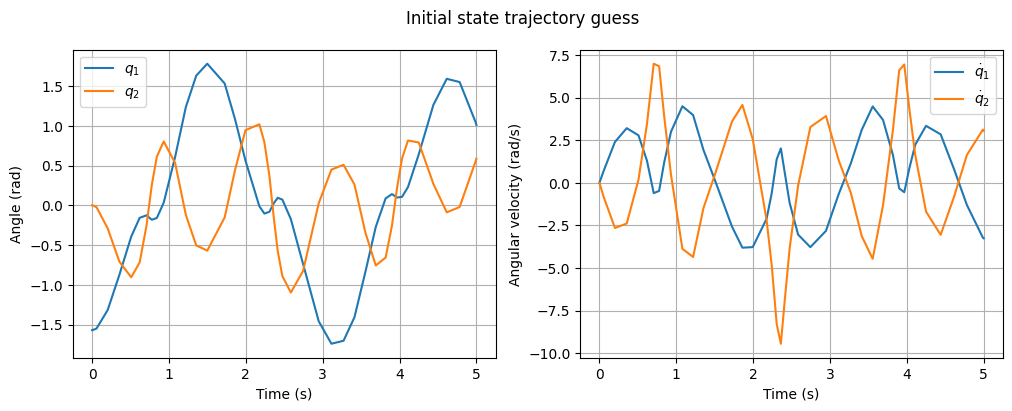

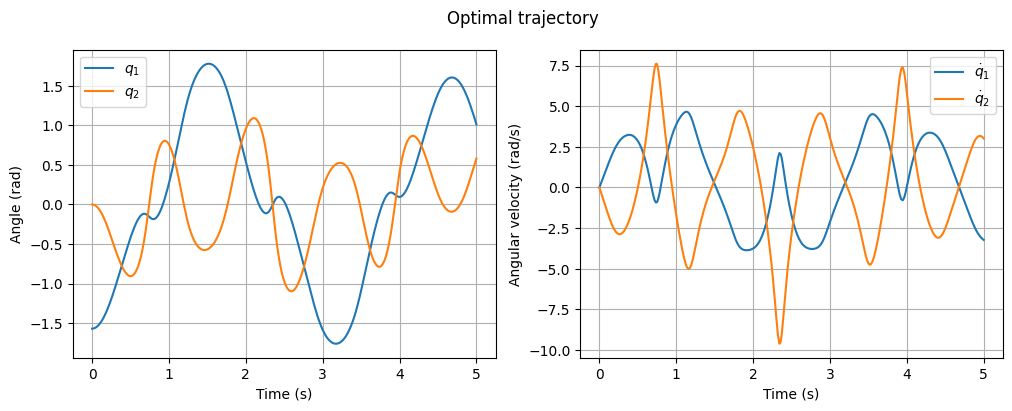

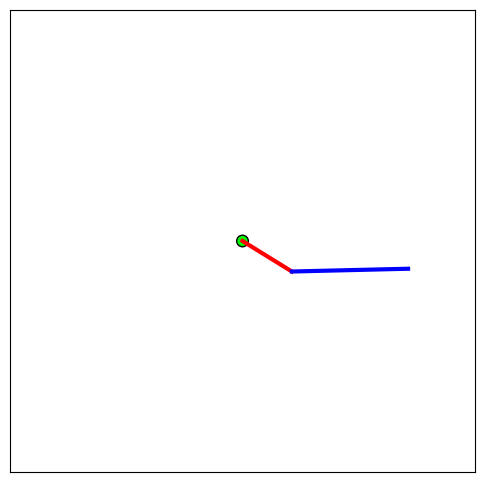

In [7]:
u_max = 0
t0 = 0
tf = 5.
x0 = [-np.pi/2, 0, 0, 0]

time, state, _, _, _, _ = acrobot_swing_up(dynamics_tedrake, lambda *args: 0,
                                           u_max, t0, tf, x0)
q1, q2, q1_dot, q2_dot = state
plot_state(time, q1, q2, q1_dot, q2_dot, title="Optimal trajectory")
anim = animate(q1, q2, drawframe_tedrake, dt_sec=tf/len(time))
anim

## Swing-up from zero position

Now let's consider the swing-up problem, starting from the zero or downward position. The zero position of the acrobot (both links straight down in line with gravity) is a stable fixed point. We want to swing the acrobot up from this position to the unstable fixed point at the top (both links still in line with gravity, but pointing up).

### Use coarse known solution as initial guess

To start, we can try seeding the solver with just a few points that coarsely specify a swing-up solution. This known solution comes from [3]. Unsurprisingly, the solver converges pretty quickly to a simple swing-up trajectory.

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    21226
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3592

Total number of variables............................:     1958
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      361
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1601
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.29e+02 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

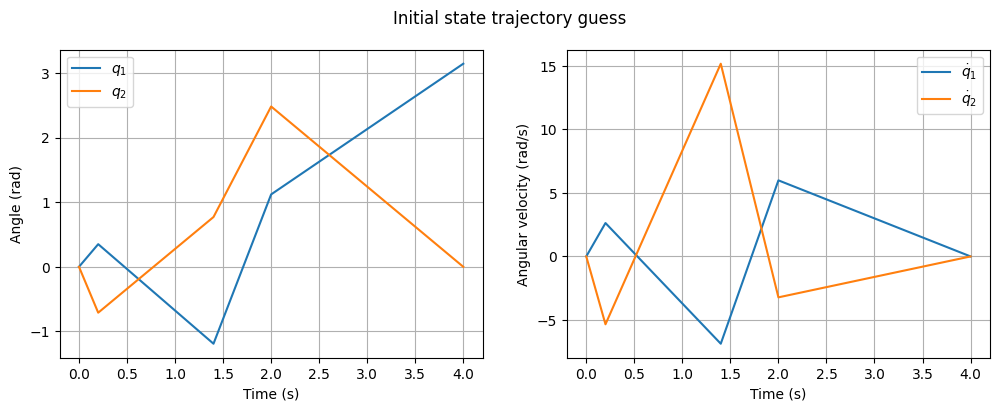

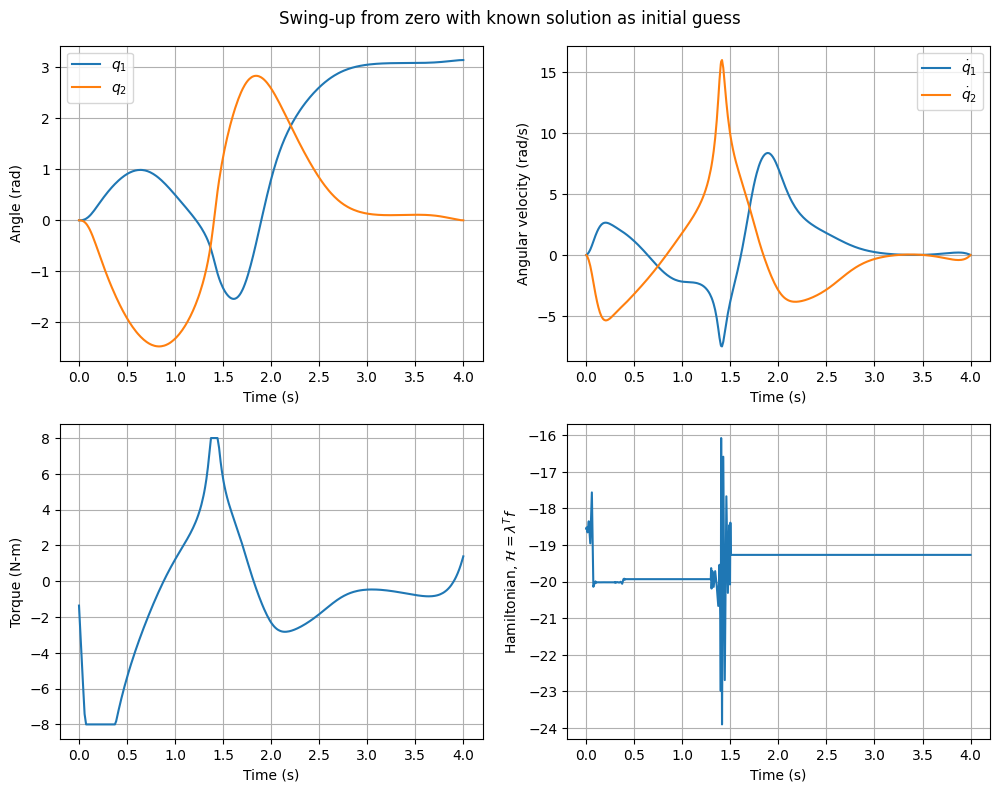

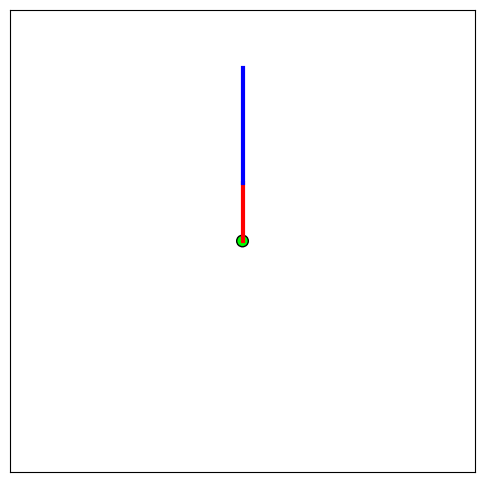

In [57]:
u_max = 8  # N-m
t0 = 0
tf = 4.
x0 = [0, 0, 0, 0]
xf = [np.pi, 0, 0, 0]
Q = 0  # state cost
R = 10  # input cost
cost_fn = cost_u_only

# Source: https://underactuated.csail.mit.edu/trajopt.html#section3
KNOWN_SOLUTION_TIME = [0.0, 0.2, 1.4, 2.0, 4.0]
KNOWN_SOLUTION_STATE = [[x0[0], 0.35, -1.19, 1.12, xf[0]],
                        [x0[1], -0.71, 0.77, 2.48, xf[1]],
                        [x0[2], 2.63, -6.87, 5.99, xf[2]],
                        [x0[3], -5.34, 15.17, -3.22, xf[3]]]

time, state, time_u, torque, costate, dynamics = acrobot_swing_up(dynamics_tedrake, cost_fn,
                                                                  u_max, t0, tf, x0, Q=Q, R=R, xf=xf,
                                                                  state_guess=KNOWN_SOLUTION_STATE,
                                                                  time_guess=KNOWN_SOLUTION_TIME)
q1, q2, _, _ = state
plot_all(time, state, time_u, torque, costate, dynamics, cost_fn=cost_fn, Q=Q, R=R, title="Swing-up from zero with known solution as initial guess")
anim = animate(q1, q2, drawframe_tedrake, dt_sec=tf/len(time))
anim

### Use reversed damped falling dynamics as initial guess
What if we don't have a known trajectory handy? Instead, as an initial guess, we can simulate the dynamics of the acrobot falling from the unstable fixed point with damping at the joints and seed our solver with the reverse of these dynamics. We do still need to have an idea of how long the swing-up will take, and we need our damping to sufficiently mirror our torque limits (that is, a very low torque limit should correspond to less damping).

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    21226
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3592

Total number of variables............................:     1958
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      361
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1601
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.52e+03 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

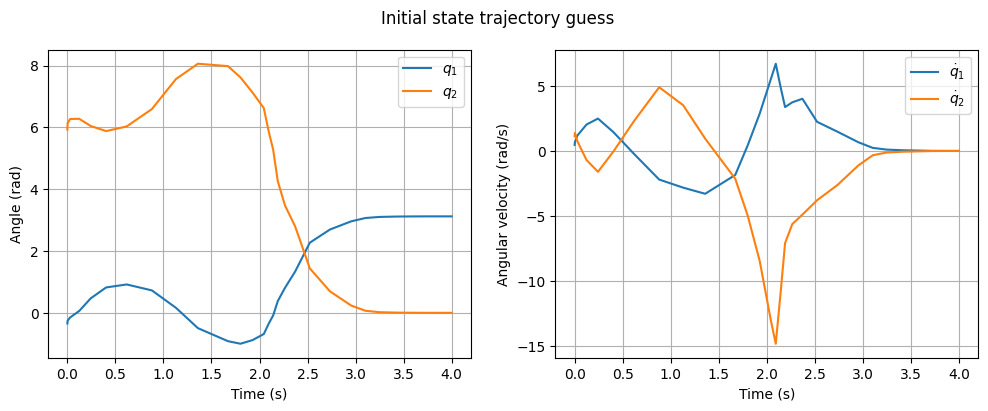

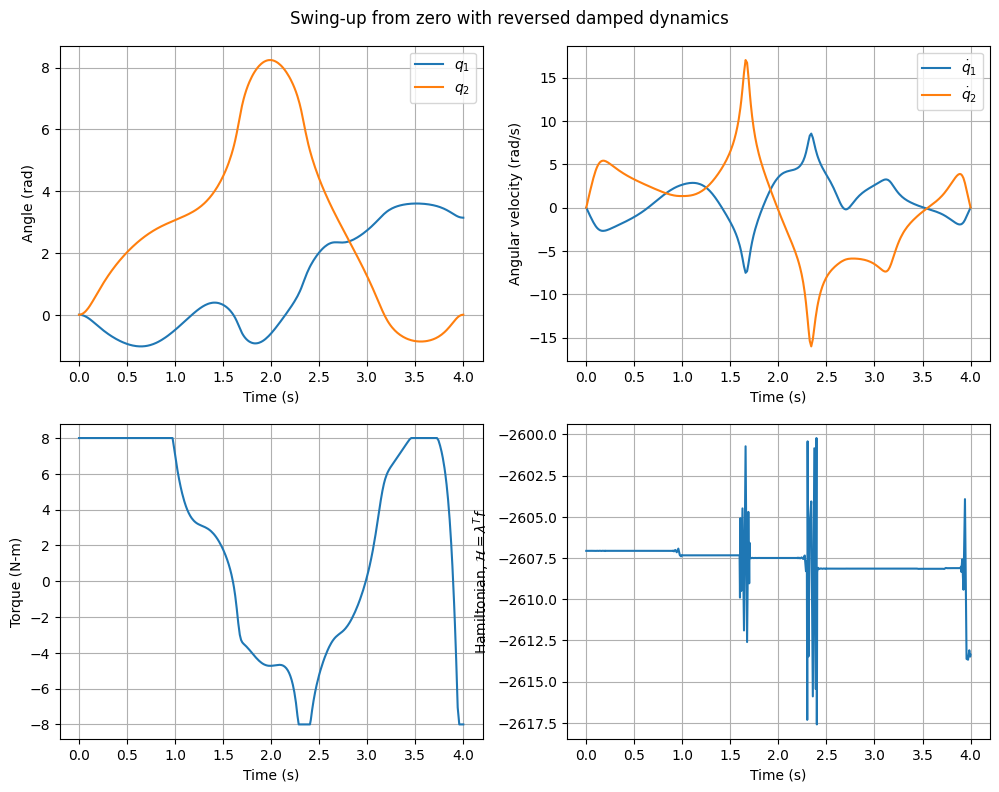

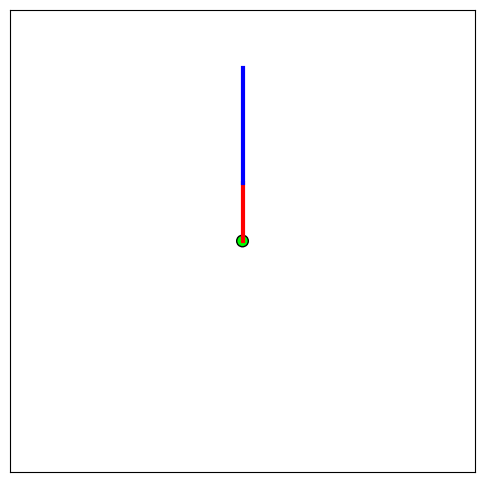

In [66]:
u_max = 8  # N-m
t0 = 0
tf = 4
x0 = [0, 0, 0, 0]
xf = [np.pi, 0, 0, 0]
Q = 0  # state cost
R = 10  # input cost
cost_fn = cost_u_only

# Damping coefficients
b1 = 2

time, state, time_u, torque, costate, dynamics = acrobot_swing_up(dynamics_tedrake, cost_fn,
                                                                  u_max, t0, tf, x0, Q=Q, R=R, xf=xf,
                                                                  b1=b1)
q1, q2, _, _ = state
plot_all(time, state, time_u, torque, costate, dynamics, cost_fn=cost_fn, Q=Q, R=R, title="Swing-up from zero with reversed damped dynamics")
anim = animate(q1, q2, drawframe_tedrake, dt_sec=tf/len(time))
anim

This trajectory works as well! But perhaps our acrobot cannot physically have the lower link rotate all the way around, so we need to impose state constraints on the problem. We can restrict $q_2$ to be within $(-\pi, \pi)$ and put very loose bounds on the remaining states (bounds which shouldn't be active anyway).

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    21226
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3592

Total number of variables............................:     1958
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1797
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1601
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.80e+03 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

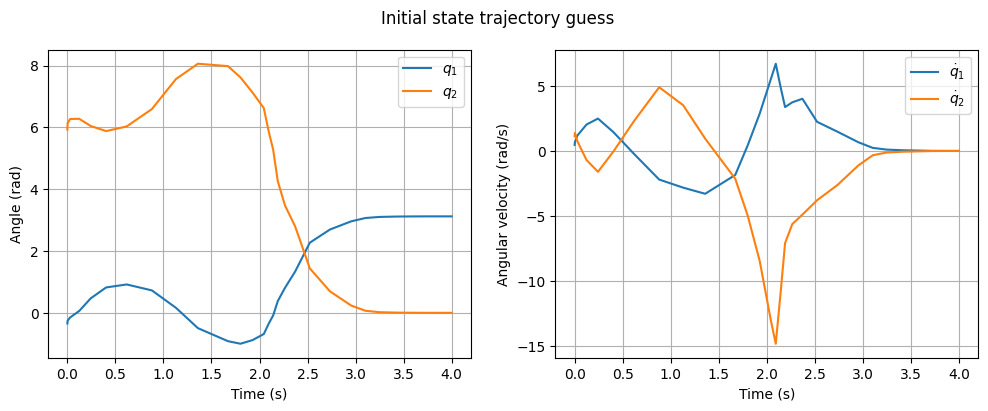

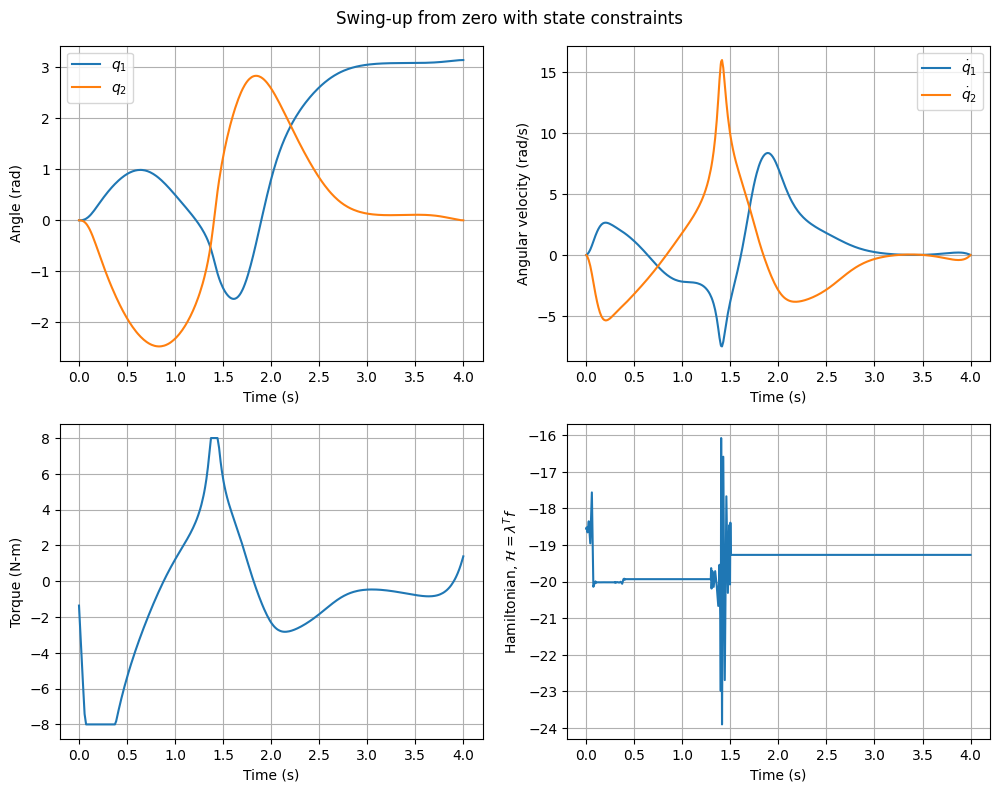

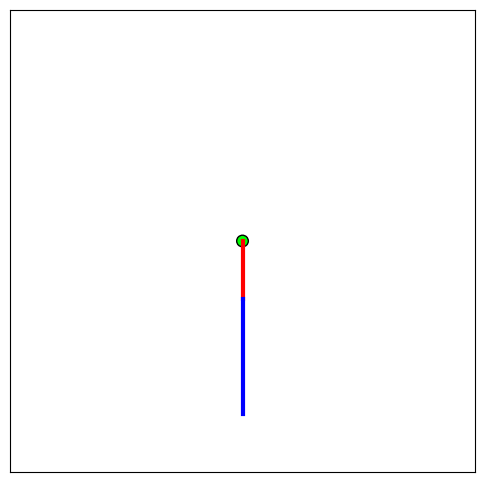

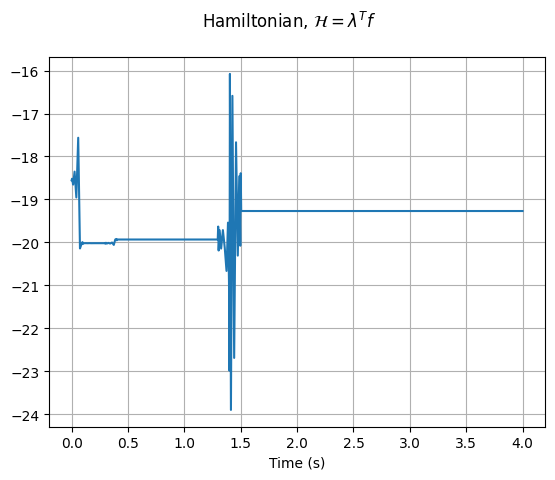

In [67]:
u_max = 8  # N-m
x_max = [10*np.pi, np.pi, 100, 100]
t0 = 0
tf = 4
x0 = [0, 0, 0, 0]
xf = [np.pi, 0, 0, 0]
Q = 0  # state cost
R = 10  # input cost
cost_fn = cost_u_only

# Damping coefficients
b1 = 2

time, state, time_u, torque, costate, dynamics = acrobot_swing_up(dynamics_tedrake, cost_fn,
                                                                  u_max, t0, tf, x0, Q=Q, R=R, xf=xf,
                                                                  x_max=x_max, b1=b1)
q1, q2, _, _ = state
plot_all(time, state, time_u, torque, costate, dynamics, cost_fn=cost_fn,
         Q=Q, R=R, title="Swing-up from zero with state constraints")
anim = animate(q1, q2, drawframe_tedrake, dt_sec=tf/len(time))
anim

### Restrict the maximum torque allowed
As we reduce the maximum torque allowed, the acrobot must swing more times to add sufficient energy to reach the upward position. To account for this, the final trajectory time must also be increased. We can see below that we can cut the torque limit in half twice and still find a valid solution, as long as the final time boundary condition is long enough. Too short, and the solver will reach a point of local infeasibility and fail.

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    21226
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3592

Total number of variables............................:     1958
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1797
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1601
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.53e+02 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

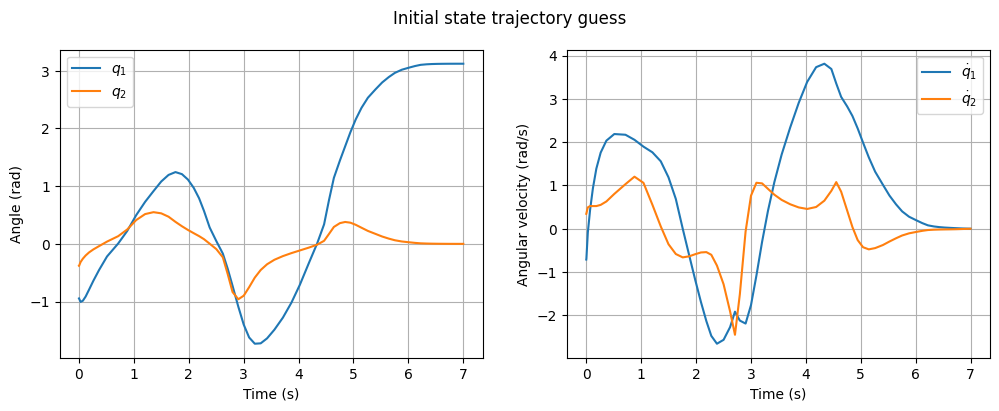

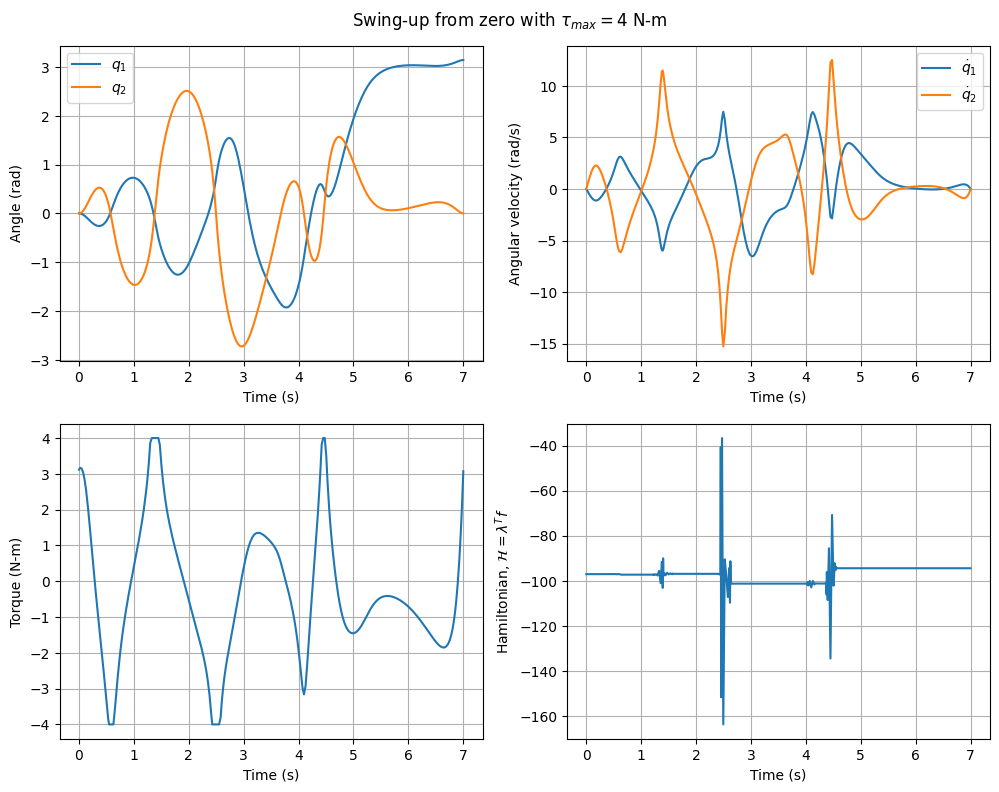

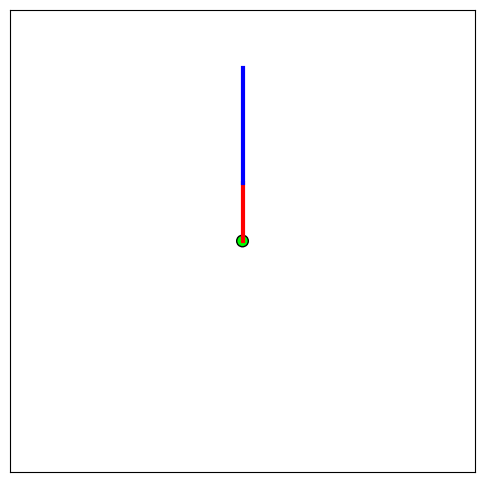

In [68]:
u_max = 4  # N-m
x_max = [10*np.pi, np.pi, 100, 100]
t0 = 0
tf = 7
x0 = [0, 0, 0, 0]
xf = [np.pi, 0, 0, 0]
Q = 0  # state cost
R = 10  # input cost
cost_fn = cost_u_only

# Damping coefficients
b1 = 1
b2 = 3

time, state, time_u, torque, costate, dynamics = acrobot_swing_up(dynamics_tedrake, cost_fn,
                                                                  u_max, t0, tf, x0, Q=Q, R=R, xf=xf,
                                                                  x_max=x_max, b1=b1, b2=b2)
q1, q2, _, _ = state
plot_all(time, state, time_u, torque, costate, dynamics, cost_fn=cost_fn,
         Q=Q, R=R, title="Swing-up from zero with $\\tau_{max} = 4$ N-m")
anim = animate(q1, q2, drawframe_tedrake, dt_sec=tf/len(time))
anim

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    21226
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3592

Total number of variables............................:     1958
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1797
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1601
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.20e+02 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

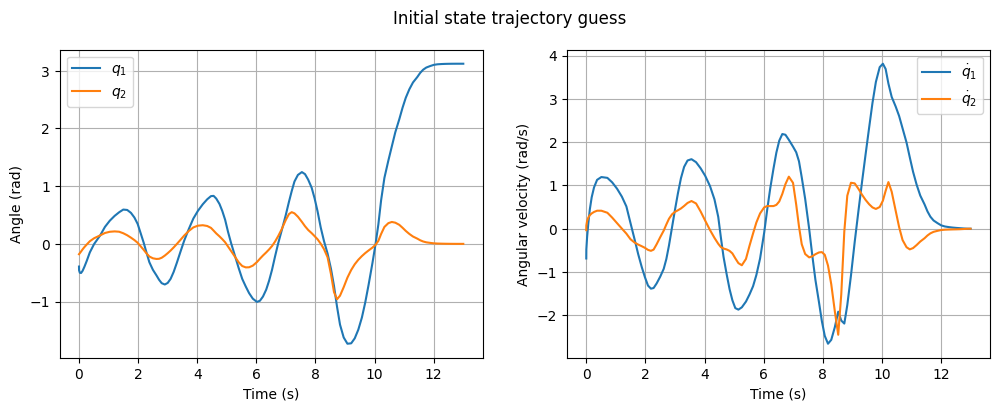

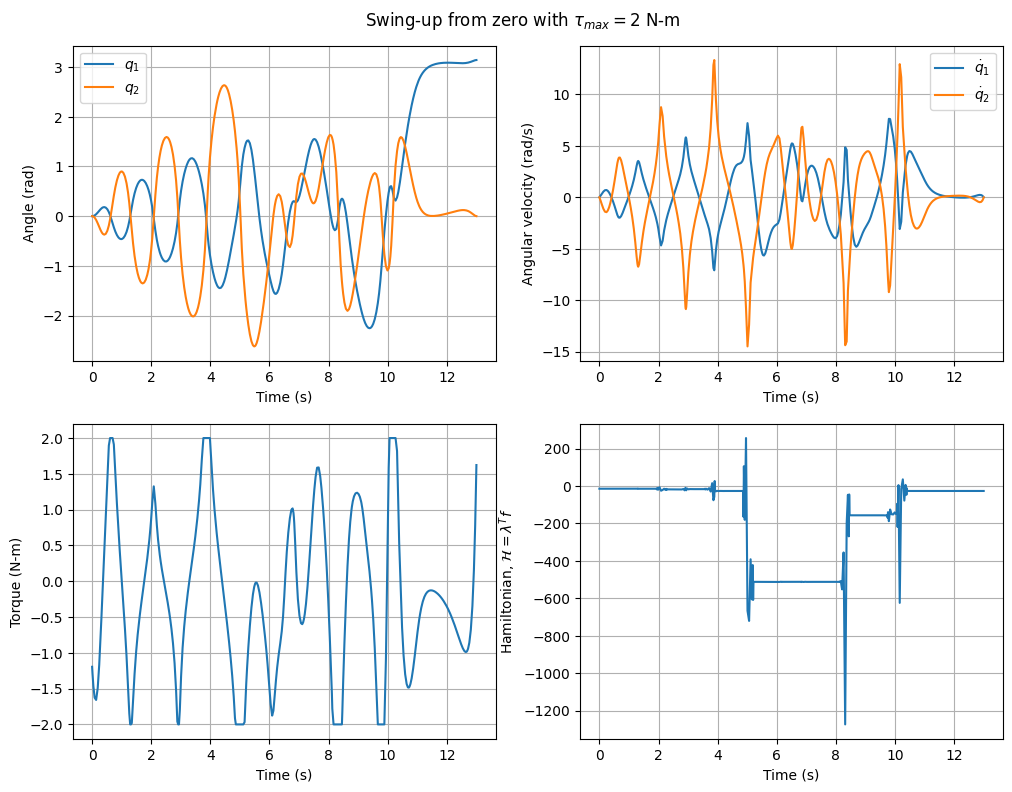

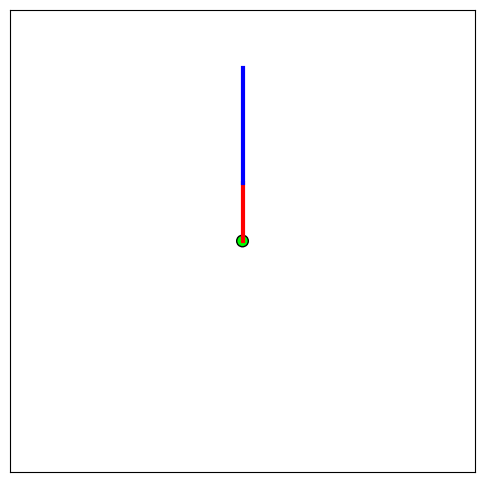

In [70]:
u_max = 2  # N-m
x_max = [10*np.pi, np.pi, 100, 100]
t0 = 0
tf = 13
x0 = [0, 0, 0, 0]
xf = [np.pi, 0, 0, 0]
Q = 0  # state cost
R = 10  # input cost
cost_fn = cost_u_only

# Damping coefficients
b1 = 1
b2 = 3

time, state, time_u, torque, costate, dynamics = acrobot_swing_up(dynamics_tedrake, cost_fn,
                                                                  u_max, t0, tf, x0, Q=Q, R=R, xf=xf,
                                                                  x_max=x_max, b1=b1, b2=b2)
q1, q2, _, _ = state
plot_all(time, state, time_u, torque, costate, dynamics, cost_fn=cost_fn,
         Q=Q, R=R, title="Swing-up from zero with $\\tau_{max} = 2$ N-m")
anim = animate(q1, q2, drawframe_tedrake, dt_sec=tf/len(time))
anim

## Swing-up from horizontal

TODO

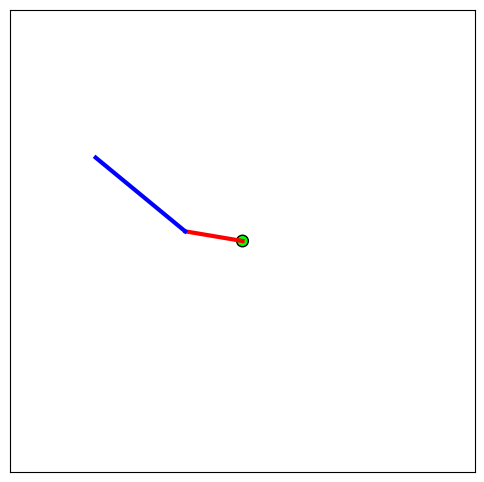

In [83]:
# TODO delete, debugging only
# Damped passive dynamics
u_max = 0
t0 = 0
tf = 3.5
x0 = [np.pi - 0.02, 0, 0, 0]
b1 = 1
b2 = 3

sol = scipy.integrate.solve_ivp(lambda t,y: dynamics_tedrake(*y, 0, b1=b1, b2=b2),
                                [t0, tf],
                                [xf[0] - 0.02, xf[1], xf[2], xf[3]])
# state_guess = [np.flip(sol.y[0]), np.flip(sol.y[1]),
#                np.flip(-1*sol.y[2]), np.flip(-1*sol.y[3])]
state_guess = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]
time = sol.t
q1, q2, q1_dot, q2_dot = state_guess

anim = animate(q1, q2, drawframe_tedrake, dt_sec=tf/len(time))
anim

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    21226
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3592

Total number of variables............................:     1958
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1797
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1601
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.58e+02 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

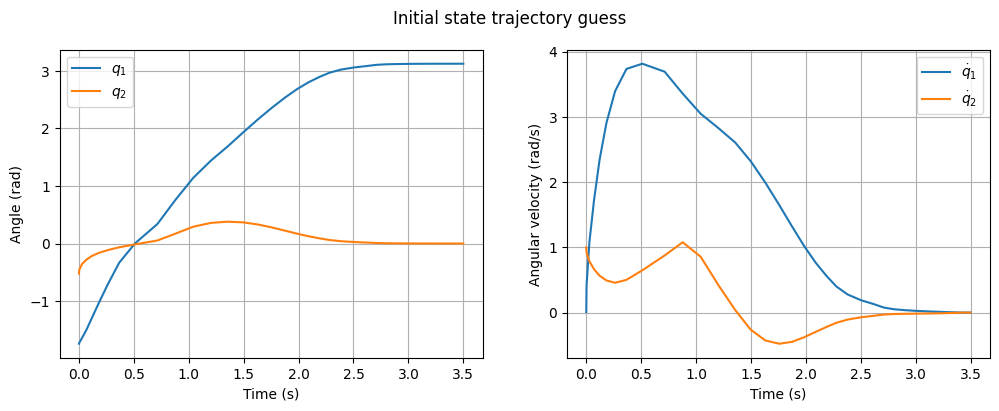

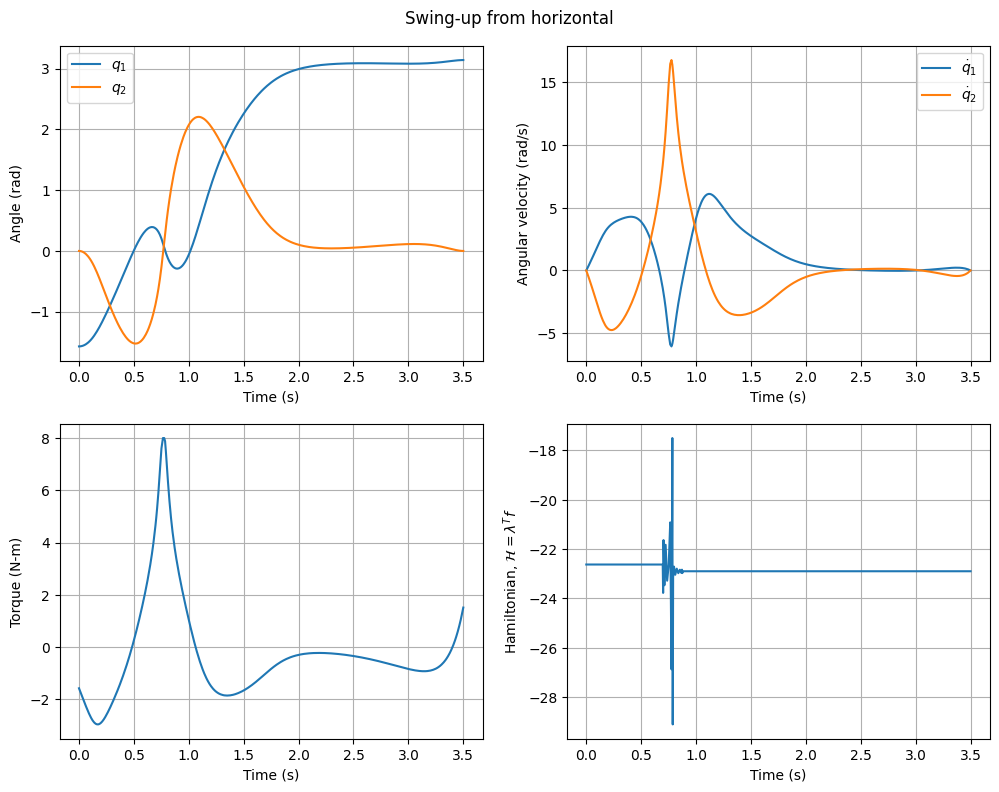

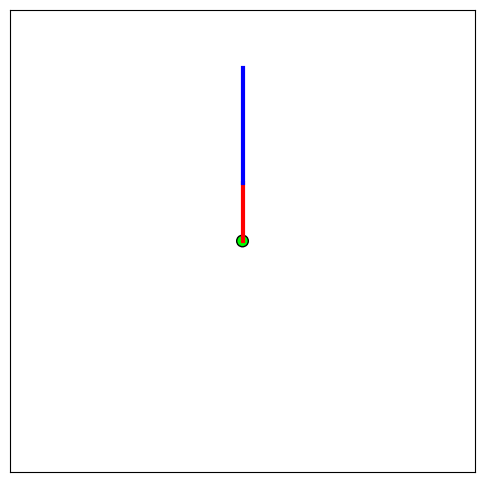

In [71]:
u_max = 8  # N-m
x_max = [10*np.pi, np.pi, 100, 100]
t0 = 0
tf = 3.5
x0 = [-np.pi/2, 0, 0, 0]
xf = [np.pi, 0, 0, 0]
Q = 0  # state cost
R = 10  # input cost
cost_fn = cost_u_only

# Damping coefficients
b1 = 1
b2 = 3

time, state, time_u, torque, costate, dynamics = acrobot_swing_up(dynamics_tedrake, cost_fn,
                                                                  u_max, t0, tf, x0, Q=Q, R=R, xf=xf,
                                                                  x_max=x_max, b1=b1, b2=b2)
q1, q2, _, _ = state
plot_all(time, state, time_u, torque, costate, dynamics, cost_fn=cost_fn,
         Q=Q, R=R, title="Swing-up from horizontal")
anim = animate(q1, q2, drawframe_tedrake, dt_sec=tf/len(time))
anim

## Adding a min-time objective and bounding (instead of fixing) the final time

Change the problem to be min-time + minimizing effort, keep the state constraints

### Swing-up from zero

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    22827
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:     5389

Total number of variables............................:     1959
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      362
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1601
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.52e+03 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

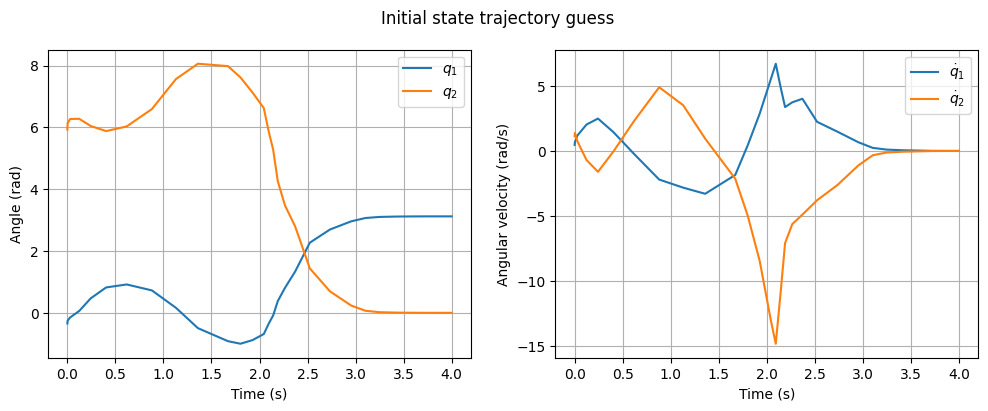

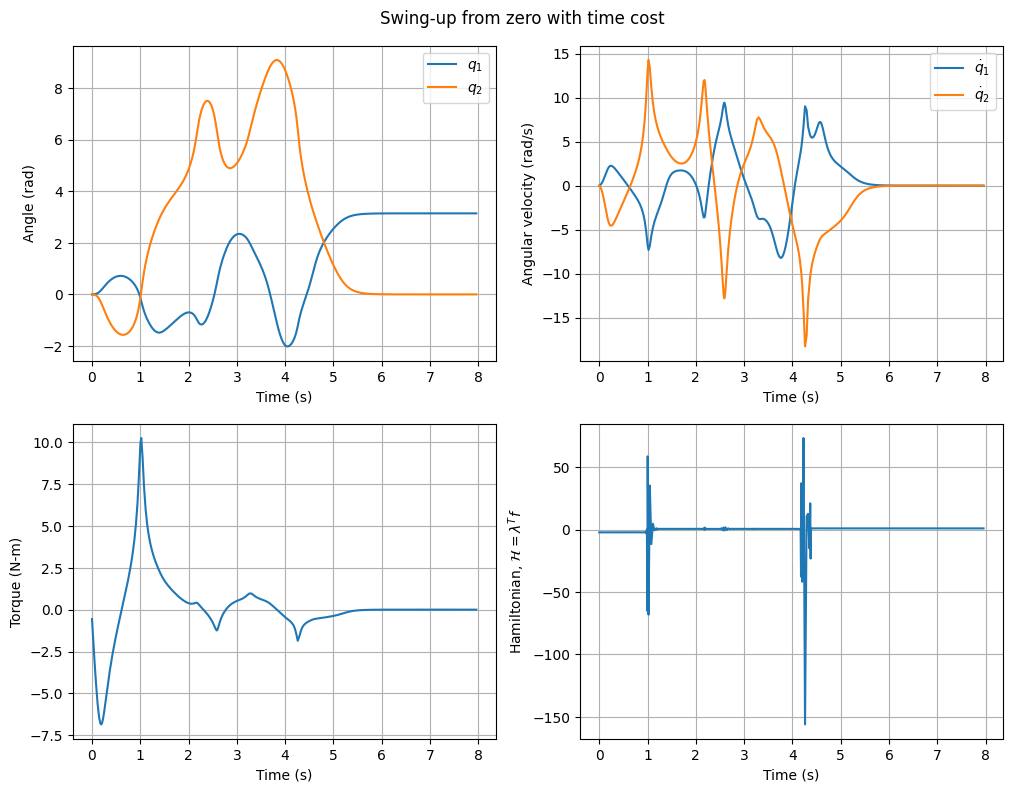

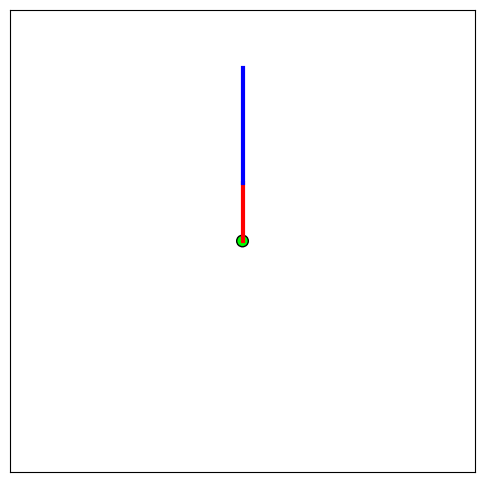

In [77]:
u_max = 12  # N-m
t0 = 0
tf = 4
x0 = [0, 0, 0, 0]
xf = [np.pi, 0, 0, 0]
Q = 0  # state cost
R = 10  # input cost
cost_fn = cost_min_u_t

# Damping coefficients
b1 = 2

time, state, time_u, torque, costate, dynamics = acrobot_swing_up(dynamics_tedrake, cost_fn,
                                                                  u_max, t0, tf, x0, Q=Q, R=R, xf=xf,
                                                                  b1=b1, min_time=True)
q1, q2, _, _ = state
plot_all(time, state, time_u, torque, costate, dynamics, cost_fn=cost_fn, Q=Q, R=R, title="Swing-up from zero with time cost")
anim = animate(q1, q2, drawframe_tedrake, dt_sec=tf/len(time))
anim

### Swing-up from horizontal

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    22827
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:     5389

Total number of variables............................:     1959
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1798
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1601
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.06e+03 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

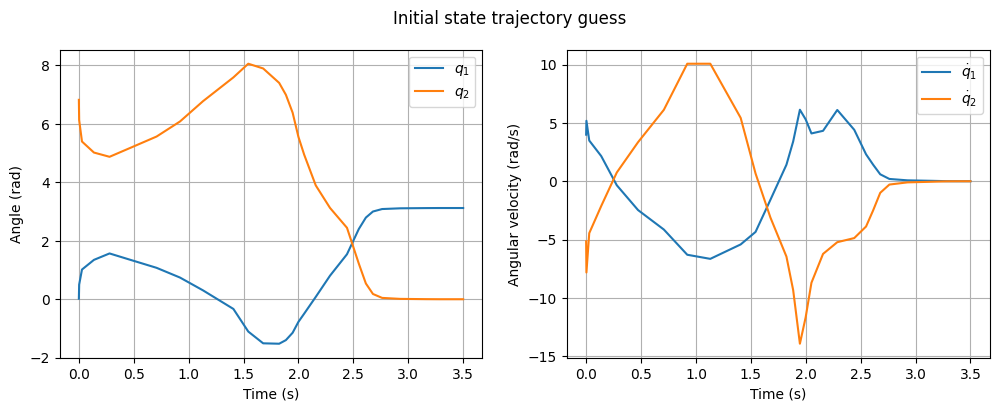

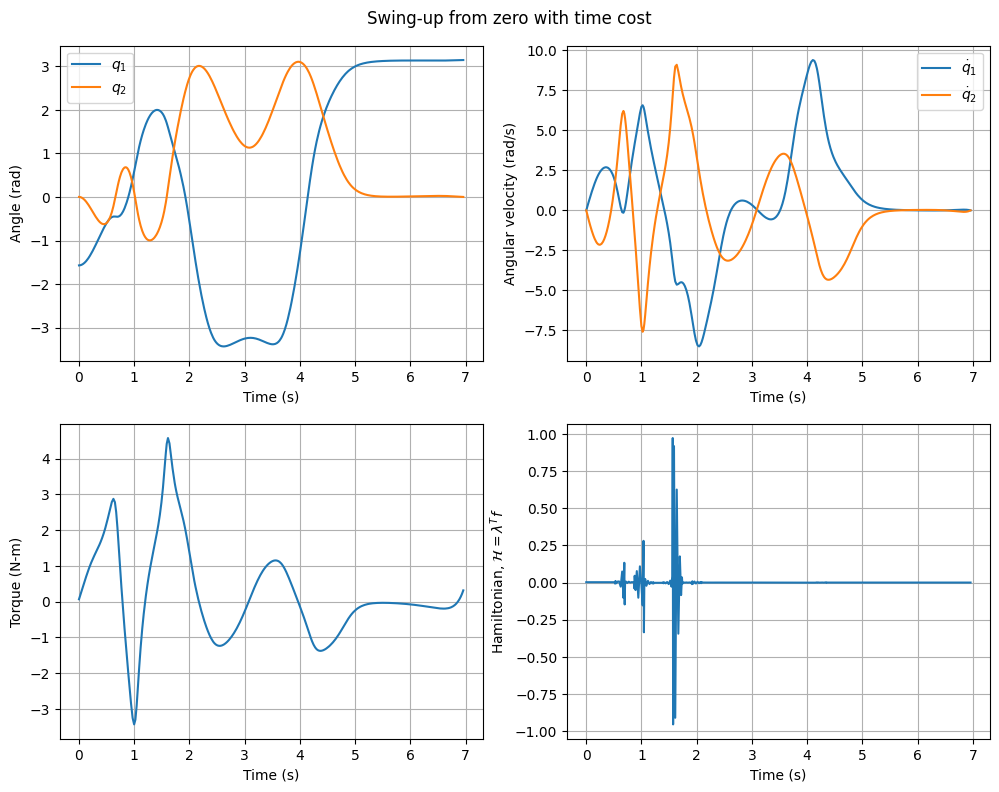

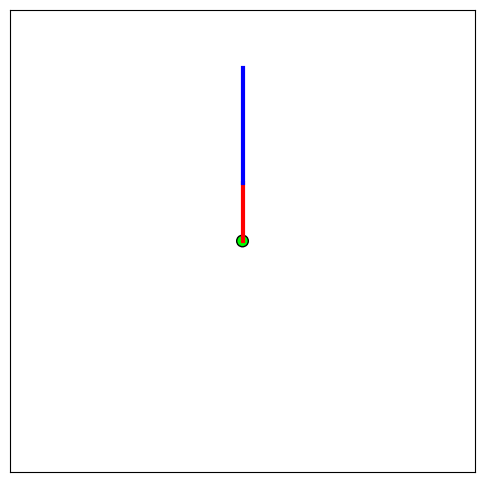

In [88]:
u_max = 15  # N-m
x_max = [10*np.pi, np.pi, 100, 100]
t0 = 0
tf = 3.5
x0 = [-np.pi/2, 0, 0, 0]
xf = [np.pi, 0, 0, 0]
Q = 0  # state cost
R = 10  # input cost
cost_fn = cost_min_u_t

# Damping coefficients
b1 = 1
b2 = 3

time, state, time_u, torque, costate, dynamics = acrobot_swing_up(dynamics_tedrake, cost_fn,
                                                                  u_max, t0, tf, x0, x_max=x_max,
                                                                  Q=Q, R=R, xf=xf,
                                                                  b1=b1, min_time=True)
q1, q2, _, _ = state
plot_all(time, state, time_u, torque, costate, dynamics, cost_fn=cost_fn, Q=Q, R=R, title="Swing-up from zero with time cost")
anim = animate(q1, q2, drawframe_tedrake, dt_sec=tf/len(time))
anim

# References
[1] Mark Spong, "The Swingup Control Problem for the Acrobot", IEEE Control Systems Magazine, vol. 15, no. 1, pp. 49-55, February, 1995.  
[2]  
[3] Russ Tedrake. Underactuated Robotics: Algorithms for Walking, Running, Swimming, Flying, and Manipulation (Course Notes for MIT 6.832). Downloaded on April 29, 2024 from https://underactuated.csail.mit.edu/.